In [1]:
import numpy as np
import os
import glob
import pandas as pd
from sklearn.manifold import Isomap,\
                            LocallyLinearEmbedding,\
                            SpectralEmbedding,\
                            TSNE,\
                            locally_linear_embedding
from umap import UMAP
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import ParameterGrid

from joblib import Parallel, delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from utils import transform, calculate_Q_metrics, KNN_MAE
from IPython.display import clear_output
N_CPU = cpu_count()

import warnings
warnings.simplefilter("ignore")
plt.rcParams.update({'font.size': 20})

# Load data

In [55]:
DATA_SPECIFICATION = '_pat0.7'

intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict{DATA_SPECIFICATION}.npy', allow_pickle=True).item()

data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values

data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
embeddings_root = f'results/embeddings{DATA_SPECIFICATION}'
embeddings_params_root = f'results/embeddings_params{DATA_SPECIFICATION}/'

os.makedirs(embeddings_root, exist_ok=True)
os.makedirs(embeddings_params_root, exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]


In [15]:
# # uncomment to use synthetic data

# intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

    
# embeddings_root = 'results/embeddings_synthetic'
# embeddings_params_root = 'results/embeddings_params_synthetic/'

# os.makedirs(embeddings_root, exist_ok=True)
# os.makedirs(embeddings_params_root, exist_ok=True)

# Hyperparameters Grid Search

In [56]:
# setting `include_Q_scores = True` significantly impedes the hyperparameter search,
# but allows to estimate Q-metrics for every combination
include_Q_scores = False

knn_mae_scorer = lambda *args: KNN_MAE(*args, averaging='median', weights='distance', n_neighbors=5)

if include_Q_scores:
    scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])
else:
    scorer = knn_mae_scorer

In [57]:
baseline_errors = {}
for label, X in tqdm((data_pca.items())):
    baseline_errors[label] = knn_mae_scorer(X,X)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.22it/s]


In [ ]:
mf_models = {
    
            'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[5,10,15,25],
                                                      'p':[1,2],
                                                      'metric':['minkowski'],
                                                      'n_jobs':[1]
                                                     }
                      },
    
    
            'spectral':{'class':SpectralEmbedding, 'params_grid':{'affinity':['nearest_neighbors', 'rbf'],
                                                                   'n_neighbors':[5,10,15,25],
                                                                   'gamma':[1e-4, 1e-3, 1e-2, None, 1e-1],
                                                                   'random_state':[42],
                                                                   'n_jobs':[1]
                                                                  }
                        },
    

            'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['ltsa', 'standard'],
                                                       'reg':[0.0001, 0.001, 0.01],
                                                       'n_neighbors':[10,15,25,50],
                                                       'random_state':[42],
                                                       'n_jobs':[1],
                                                       'eigen_solver':['dense']
                                                     }
                  },
    
            'umap':{'class':UMAP, 'params_grid':{'n_neighbors':[5,10,15,25,50],
                                                 'min_dist':[0.05, 0.1, 0.25, 0.5],
                                                 'learning_rate':[0.1, 1],
                                                 'random_state':[42],
                                                 'metric':['manhattan'],
                                                 'n_epochs':[2000], # changerd from 2000
                                                 'n_jobs':[1]
                                                }
                   },
    
            'tsne':{'class':TSNE, 'params_grid':{'perplexity':[5,10,15,25,50],
                                                 'random_state':[42],
                                                 'early_exaggeration':[5,10,25],
                                                 'init':['pca'],
                                                 'metric':['manhattan'],
                                                 'method':['exact'],
                                                 'n_jobs':[1],
                                                 'n_iter':[2000],
                                                 'n_iter_without_progress':[100]
                                                 }
                   } 
            }

# iterate over the models
for mf_type, model in mf_models.items():    
    # iterate over the datasets
    for i,(label, X) in tqdm(enumerate(data_pca.items())):
        
        results = {}
        results_path = os.path.join(embeddings_params_root,\
                                    f'pca_{mf_type}_{label}')
        
        if os.path.isfile(results_path + '.npy'):
            print(f'{results_path} exists, skipping...')
            continue

        dim = intrinsic_dims[label]
        print('Calculating...', label, 'Method:', mf_type, 'Intrinsic dim:', dim)

        model_class = model['class']
        model_param_grid = model['params_grid']
        
        try:
            scores = Parallel(n_jobs=-1)(delayed(transform)(model_class,
                                                            X, 
                                                            dim,
                                                            model_params,
                                                            scorer) \
                              for model_params in list(ParameterGrid(model_param_grid)))  
            
            results['scores'] = scores
            results['params'] = model_param_grid
            np.save(results_path, results)
            
        except Exception as e:
            print(f'Failed to estimate perameters for {mf_type}, {label}:', e)
            continue
            
clear_output()

0it [00:00, ?it/s]

Calculating... clust4_dim108 Method: tsne Intrinsic dim: 36


/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/sit

Calculating... clust4_dim70 Method: tsne Intrinsic dim: 28


/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/sit

Calculating... clust2_dim39 Method: tsne Intrinsic dim: 22


/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/sit

Calculating... clust3_dim70 Method: tsne Intrinsic dim: 29


/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/sit

4it [3:48:16, 3403.44s/it]

Calculating... clust2_dim70 Method: tsne Intrinsic dim: 31


/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/sit

Calculating... clust3_dim108 Method: tsne Intrinsic dim: 37


/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ibulygin/miniconda3/envs/neuro/lib/python3.8/sit

6it [6:13:09, 4003.23s/it]

Calculating... clust4_dim39 Method: tsne Intrinsic dim: 20


# Visualize KNN MAE, select best hyperparameters

In [23]:
all_metrics = defaultdict(dict)

for metrics_results_name in \
                   filter(lambda x: 'pca' in x, os.listdir(embeddings_params_root)):
    
    mf_type, dataset_name, tax_name = metrics_results_name.split('.')[0].split('_')[-3:]
    label = '_'.join([dataset_name, tax_name])
    all_metrics[mf_type][label] = np.load(os.path.join(embeddings_params_root, 
                                          metrics_results_name), \
                                          allow_pickle=True).item()

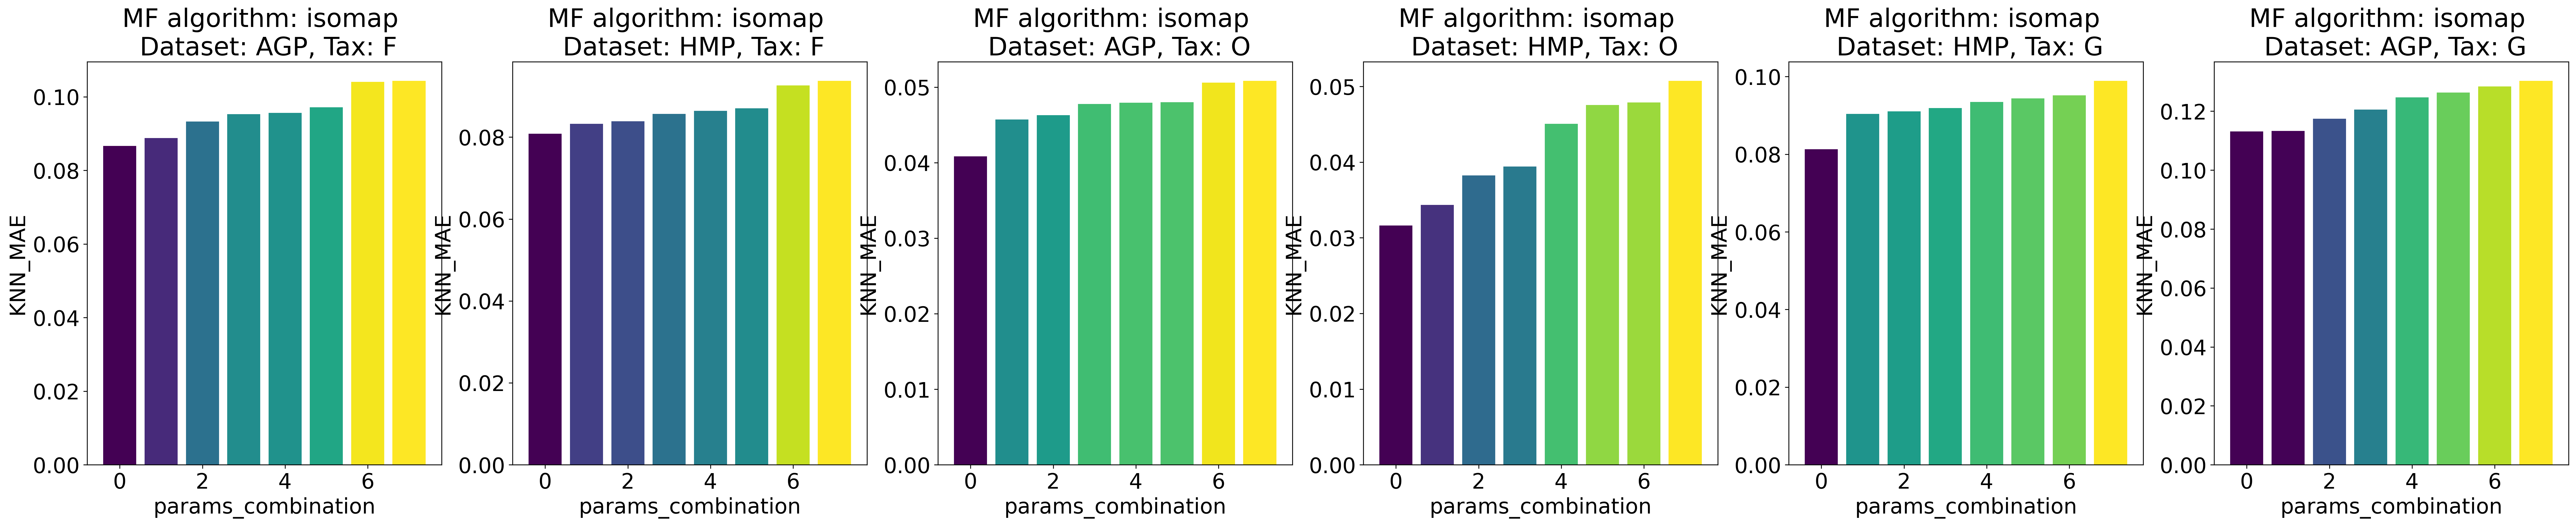

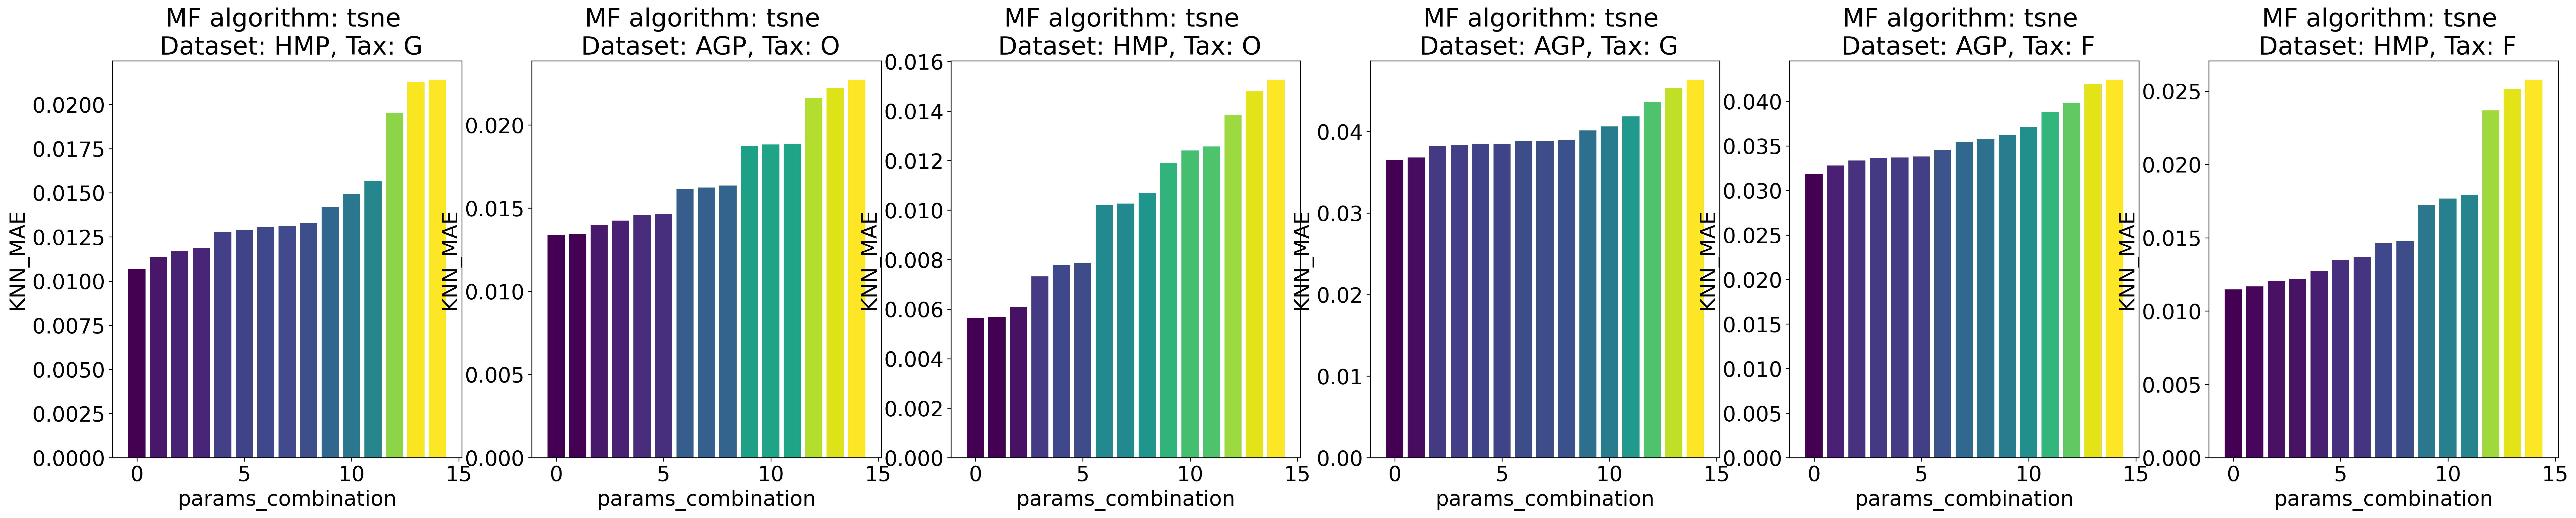

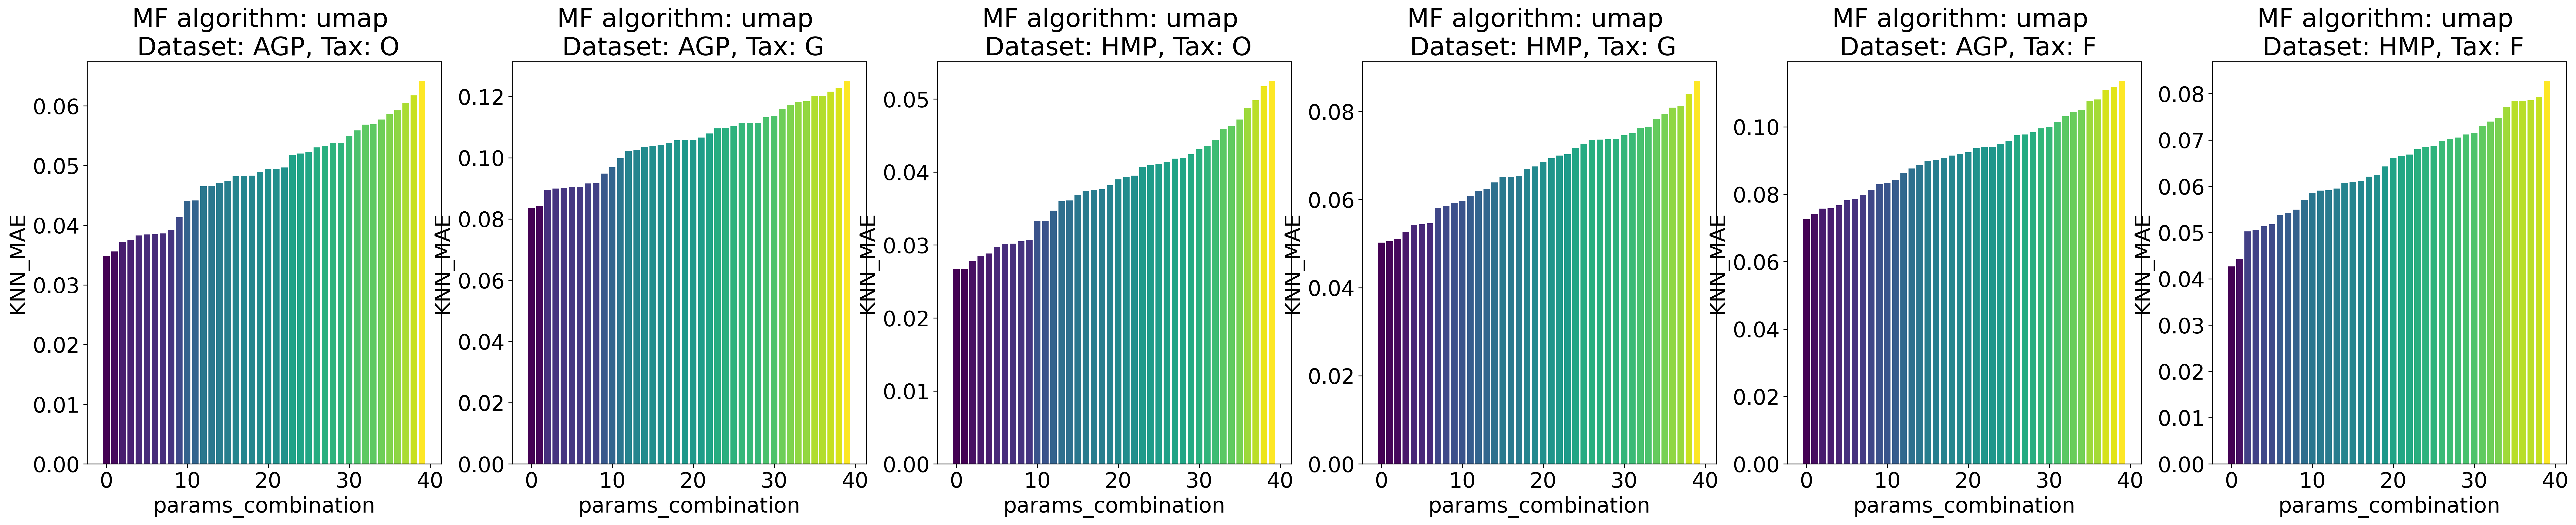

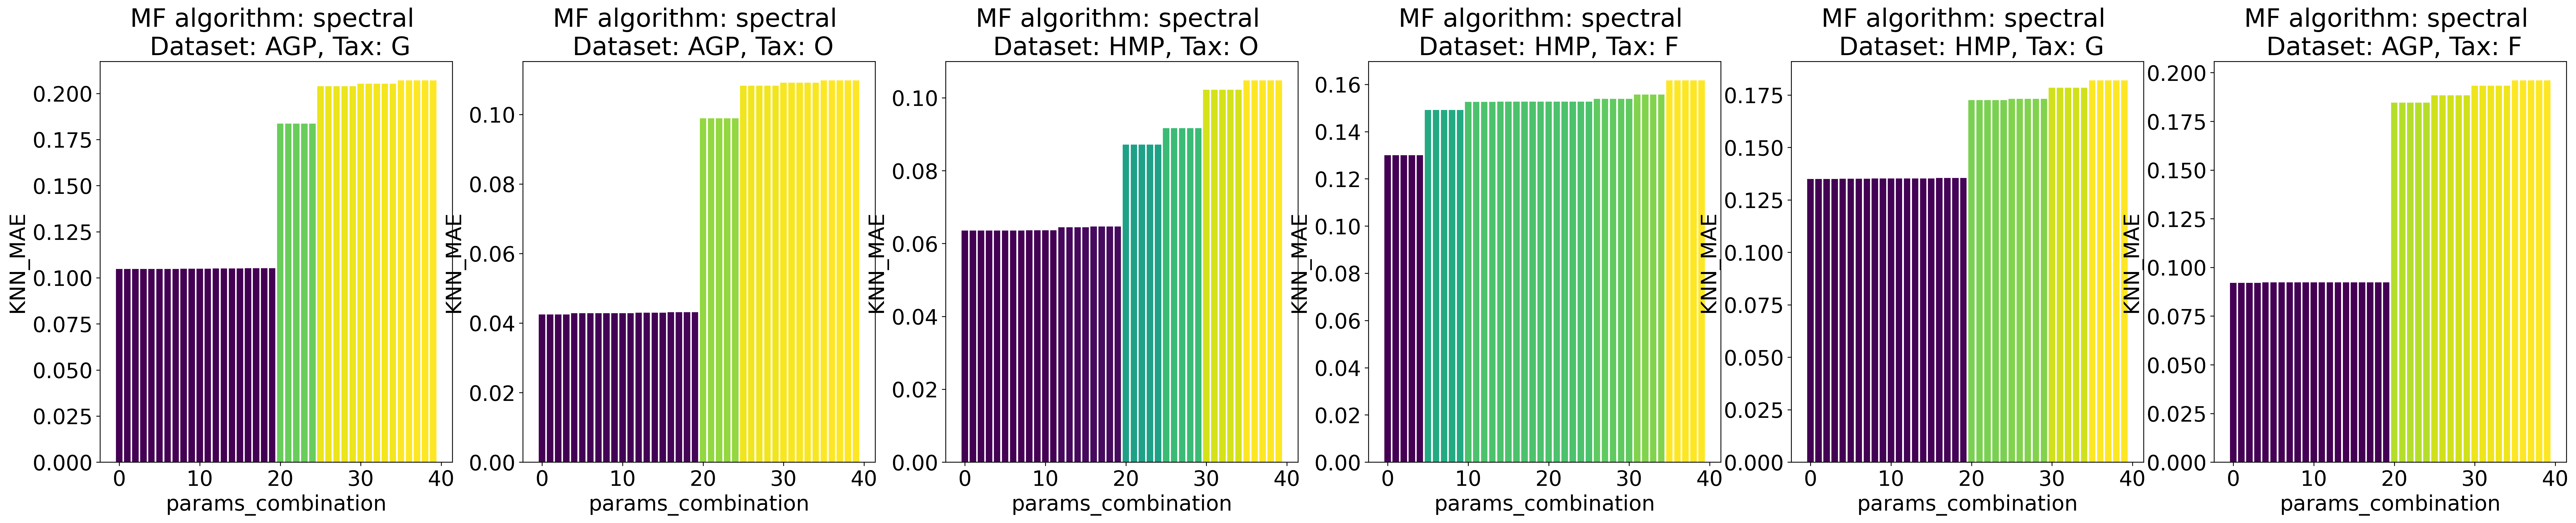

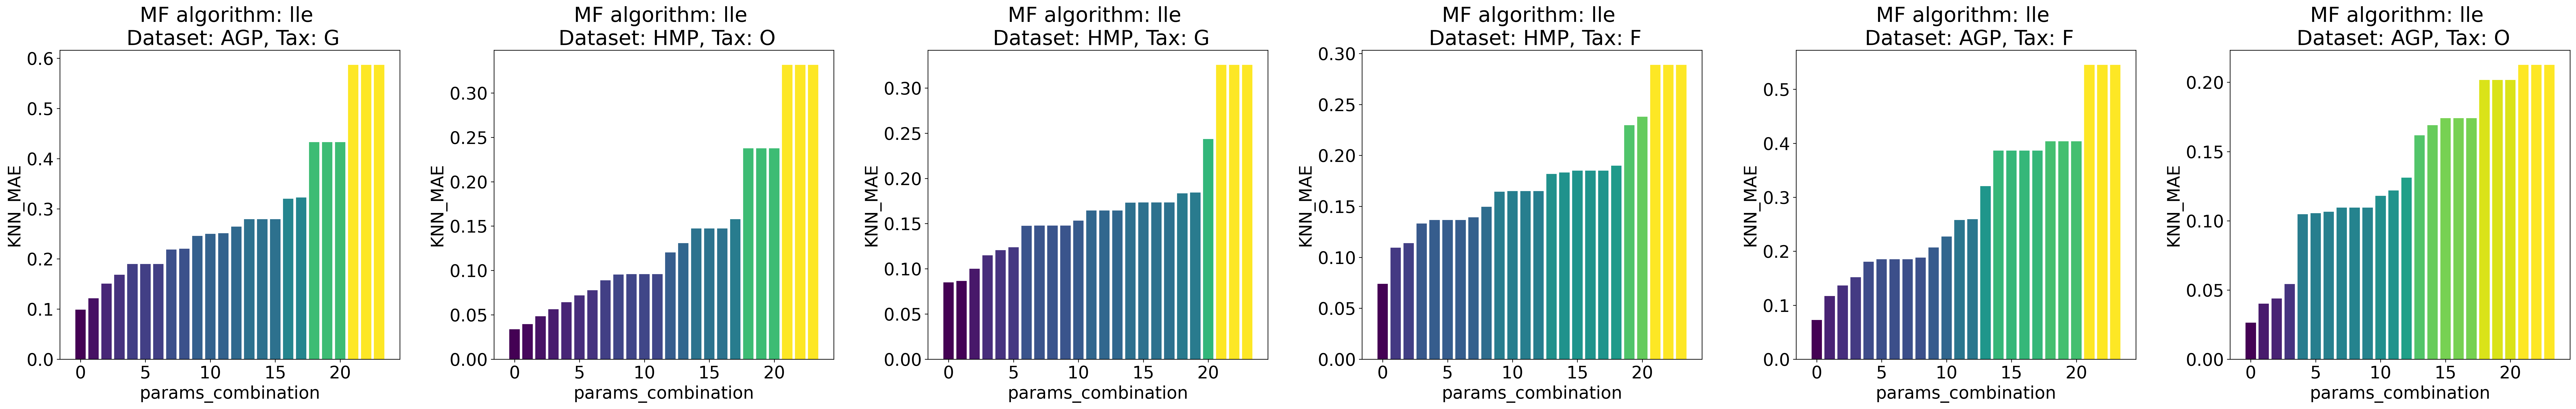

In [24]:
plt.rcParams.update({'font.size': 20})
best_params = defaultdict(dict)

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for mf_type, mf_metrics in all_metrics.items():
    mf_metrics_items = mf_metrics.items()
    
    fig, axes = plt.subplots(nrows=1, 
                             ncols = len(mf_metrics_items), 
                             figsize=(len(mf_metrics_items)*7, 7), 
                             dpi=300)
    
    for i,(label, mf_label_metrics) in enumerate(mf_metrics_items):
        
        scores = np.array(mf_label_metrics['scores'])
        params = list(ParameterGrid(mf_label_metrics['params']))
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1]
        
        if include_Q_scores:
            maes = scores[:,-1]
        else:
            maes = scores
            
        mae_argmin = maes.argmin()
        
        best_params[label][mf_type] = params[mae_argmin] 
        
        # scatterplot with Q-metrics
        if include_Q_scores:
            sc = axes[i].scatter(scores[:,0], scores[:,1], c=scores[:,2])
            axes[i].set_xlabel('Q_loc')
            axes[i].set_ylabel('Q_glob')
        
        else:
            scores_rel = scores - baseline_errors[label]
            scores_rel = sorted(scores_rel)
            axes[i].bar(np.arange(len(scores_rel)), scores_rel, color=my_cmap(rescale(scores_rel)))
            axes[i].set_xlabel('params_combination')
            axes[i].set_ylabel('KNN MAE')
            
        axes[i].set_title(f'MF algorithm: {mf_type} \n Dataset: {dataset_name}, Tax: {tax_name.capitalize()}')
        
            
    if include_Q_scores:
        fig.colorbar(sc, orientation='vertical')
        
plt.tight_layout()        
plt.show()

# Train final embeddings

In [21]:
methods_dict = {
                'tsne':TSNE,
                'lle':LocallyLinearEmbedding,
                'umap':UMAP,
                'isomap':Isomap,
                'spectral':SpectralEmbedding
               }

Q_mae_scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])

PERCENTILE = 95
DATA_PERCENT_THRESHOLD = 0.9

for label, best_params_ in tqdm(best_params.items()):
    
    X_pca = data_pca[label]
    X_orig  = data_orig[label]
    intdim = intrinsic_dims[label]

    for method_name, params_dict in best_params_.items():
        
        embedding_path = os.path.join(embeddings_root, f'{label}_{method_name}')
        
        if os.path.isfile(embedding_path + '.npy'):
            print(embedding_path, f'Embedding for {method_name}, {label} exists! Skipping...') 
            
            d = np.load(embedding_path + '.npy', allow_pickle=True).item()
            
            mae = d['knn_mae']
            Q_loc = d['Q_loc']
            Q_glob = d['Q_glob']
            baseline_mae = d['knn_mae_base']
            
            mae_ = d['knn_mae_']
            Q_loc_ = d['Q_loc_']
            Q_glob_ = d['Q_glob_']
            baseline_mae_ = d['knn_mae_base_']
            
        else:
            print(embedding_path, f'Calculating for {method_name}, {label}...')  

            params_dict['n_jobs'] = -1

            # assert large `n_iter` for the final embedding
            if method_name == 'tsne':
                params_dict['n_iter'] = 2000
            elif method_name == 'umap':
                params_dict['n_epochs'] = 2000

            Z = methods_dict[method_name](n_components=intdim, **params_dict).fit_transform(X_pca)
            d = {'Z':Z}

            mae = knn_mae_scorer(X_orig, Z)
            baseline_mae = knn_mae_scorer(X_orig, X_orig)
            Q_loc, Q_glob = calculate_Q_metrics(X_orig, Z)

            d['Q_loc'] = Q_loc
            d['Q_glob'] = Q_glob
            d['knn_mae'] = mae
            d['knn_mae_base'] = baseline_mae 

            N = X_orig.shape[0]
            X_ = X_orig.copy()
            Z_ = Z.copy() 

            inliers_indexes = np.arange(N)
            # iteratively choosing subset of high-mae outliers
            maxiter = 20
            for _ in range(maxiter):
                scoring_list = KNN_MAE(X_, Z_, averaging=None, weights='distance', n_neighbors=5) 
                q = np.percentile(scoring_list, PERCENTILE)
                mask = scoring_list < q
                if mask.sum()/N < DATA_PERCENT_THRESHOLD:
                    break
                X_ = X_[mask]
                Z_ = Z_[mask]
                inliers_indexes = inliers_indexes[mask]

            outliers_indexes = set(np.arange(N)) - set(inliers_indexes)
            # cast set to np.array
            outliers_indexes = np.array(list(outliers_indexes))

            mae_ = knn_mae_scorer(X_, Z_)
            baseline_mae_ = knn_mae_scorer(X_, X_)
            Q_loc_, Q_glob_ = calculate_Q_metrics(X_, Z_)

            d['inliers_indexes_mae'] = inliers_indexes
            d['outliers_indexes_mae'] = outliers_indexes
            d['X_'] = X_
            d['Z_'] = Z_ # final embedding
            d['Q_loc_'] = Q_loc_ 
            d['Q_glob_'] = Q_glob_ 
            d['knn_mae_'] = mae_ # final mae
            d['knn_mae_base_'] = baseline_mae_ 

            np.save(embedding_path, d)   

        print(f'Initial metrics: mae={mae}, Q_loc={Q_loc}, Q_glob={Q_glob}, baseline_error: {baseline_mae}') 
        print(f'After removing outliers: mae={mae_}, Q_loc={Q_loc_}, Q_glob={Q_glob_}, baseline_error: {baseline_mae_}')
        print('-----------------------------------------------------------','\n')


  0%|                                                                                                                                          | 0/6 [00:00<?, ?it/s]

results/embeddings_pat0.7/AGP_f_isomap Embedding for isomap, AGP_f exists! Skipping...
Initial metrics: mae=0.23803128570816642, Q_loc=0.645517121083115, Q_glob=0.882632254376492, baseline_error: 0.1831295866679454
After removing outliers: mae=0.22431084473111346, Q_loc=0.665938568186723, Q_glob=0.8943238904518889, baseline_error: 0.17370566546330177
----------------------------------------------------------- 

results/embeddings_pat0.7/AGP_f_tsne Embedding for tsne, AGP_f exists! Skipping...
Initial metrics: mae=0.21213508953719185, Q_loc=0.5305001912585289, Q_glob=0.7958556046023854, baseline_error: 0.1831295866679454
After removing outliers: mae=0.1988596443236802, Q_loc=0.55799389650158, Q_glob=0.8208337531525844, baseline_error: 0.17359414318336225
----------------------------------------------------------- 

results/embeddings_pat0.7/AGP_f_umap Embedding for umap, AGP_f exists! Skipping...
Initial metrics: mae=0.22991983317134473, Q_loc=0.5783101520817269, Q_glob=0.83272166272871

 33%|███████████████████████████████████████████▎                                                                                      | 2/6 [00:00<00:00,  5.33it/s]

Initial metrics: mae=0.22679315078707402, Q_loc=0.5708916510300258, Q_glob=0.8223162454382908, baseline_error: 0.1831295866679454
After removing outliers: mae=0.21297201904488255, Q_loc=0.5906636776726799, Q_glob=0.8278513157251312, baseline_error: 0.17362724658763973
----------------------------------------------------------- 

results/embeddings_pat0.7/AGP_f_lle Embedding for lle, AGP_f exists! Skipping...
Initial metrics: mae=0.2271196345959299, Q_loc=0.56960265683568, Q_glob=0.8212226491768454, baseline_error: 0.1831295866679454
After removing outliers: mae=0.2124817466628896, Q_loc=0.5878913795778423, Q_glob=0.8274222918066386, baseline_error: 0.17358315009376357
----------------------------------------------------------- 

results/embeddings_pat0.7/HMP_f_isomap Embedding for isomap, HMP_f exists! Skipping...
Initial metrics: mae=0.3770549945425678, Q_loc=0.6090090845671782, Q_glob=0.8523384976228949, baseline_error: 0.2839457150742595
After removing outliers: mae=0.34561734976723

 50%|█████████████████████████████████████████████████████████████████                                                                 | 3/6 [00:00<00:00,  5.82it/s]

Initial metrics: mae=0.07325015109638304, Q_loc=0.6665939099217575, Q_glob=0.9084056233596248, baseline_error: 0.05336745880133058
After removing outliers: mae=0.0665267025625123, Q_loc=0.6869682363764132, Q_glob=0.9240157308512104, baseline_error: 0.04866362144254034
----------------------------------------------------------- 

results/embeddings_pat0.7/AGP_o_tsne Embedding for tsne, AGP_o exists! Skipping...
Initial metrics: mae=0.061012427632322695, Q_loc=0.5420194616453936, Q_glob=0.7324443432119955, baseline_error: 0.05336745880133058
After removing outliers: mae=0.055925673625391525, Q_loc=0.5559445455818512, Q_glob=0.7620717899603484, baseline_error: 0.04866362144254034
----------------------------------------------------------- 

results/embeddings_pat0.7/AGP_o_umap Embedding for umap, AGP_o exists! Skipping...
Initial metrics: mae=0.06897022940455866, Q_loc=0.6083856478658131, Q_glob=0.8000170905541405, baseline_error: 0.05336745880133058
After removing outliers: mae=0.0626461

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5/6 [00:00<00:00,  7.31it/s]

Initial metrics: mae=0.3575173259893779, Q_loc=0.5840607082546557, Q_glob=0.8306338639849684, baseline_error: 0.27707305422205314
After removing outliers: mae=0.33037432673575606, Q_loc=0.6045508582780718, Q_glob=0.844103397150025, baseline_error: 0.25741412093506083
----------------------------------------------------------- 

results/embeddings_pat0.7/HMP_g_tsne Embedding for tsne, HMP_g exists! Skipping...
Initial metrics: mae=0.2974193552115094, Q_loc=0.5364514712340799, Q_glob=0.7743486259348387, baseline_error: 0.27707305422205314
After removing outliers: mae=0.2773752664567116, Q_loc=0.5596070248652407, Q_glob=0.7906305790844367, baseline_error: 0.2577097291840212
----------------------------------------------------------- 

results/embeddings_pat0.7/HMP_g_umap Embedding for umap, HMP_g exists! Skipping...
Initial metrics: mae=0.33057016646836573, Q_loc=0.5638820287456081, Q_glob=0.7964089415303497, baseline_error: 0.27707305422205314
After removing outliers: mae=0.3044672409707

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.22it/s]

Initial metrics: mae=0.24760369530879148, Q_loc=0.5279839683858472, Q_glob=0.7983546783605111, baseline_error: 0.20619371245647183
After removing outliers: mae=0.2338279087750797, Q_loc=0.5393312118187328, Q_glob=0.8032435017490452, baseline_error: 0.19616557486541783
----------------------------------------------------------- 

results/embeddings_pat0.7/AGP_g_lle Embedding for lle, AGP_g exists! Skipping...
Initial metrics: mae=0.25639288828524476, Q_loc=0.5762223108430617, Q_glob=0.8318125507828183, baseline_error: 0.20619371245647183
After removing outliers: mae=0.24109194082607935, Q_loc=0.5957166271031112, Q_glob=0.8411286406176156, baseline_error: 0.19605520582911926
----------------------------------------------------------- 



# Visualize Q metrics

In [58]:
data_embeddings = defaultdict(dict)

for embedding_name in os.listdir(embeddings_root):
    dataset_name, tax_name, embedding_type = embedding_name.split('.')[0].split('_')
    embedding_path = os.path.join(embeddings_root, embedding_name)
    d = np.load(embedding_path, allow_pickle=True).item()
    label = dataset_name + '_' + tax_name
    data_embeddings[label][embedding_type] = d    

In [120]:
xytext_positions_pat07 = {
                          'AGP_o_isomap':(-60, -5),
                          'AGP_o_spectral':(-20, 10),
                          'AGP_o_lle':(-25, 7),#
                          'AGP_f_umap':(-10, 10),
                          'AGP_f_lle':(5,-10),
                          'AGP_f_ae':(5,-15), #
                          'AGP_f_spectral':(-30, -5),
                          'AGP_f_isomap':(-30, -15),#
                          'AGP_g_lle':(-30,0),#
                          'AGP_g_ae':(-25,0),
                          'AGP_g_umap':(-20,5), # 
                          'AGP_g_isomap':(-60, 0), #
                          'AGP_g_spectral':(-20, 10),#
                          'HMP_o_spectral': (10,-20),
                          'HMP_o_lle': (10,-10), #
                          'HMP_o_umap': (10,-20),
                          'HMP_o_isomap': (-30, -20),
                          'HMP_f_lle': (-15, -20), 
                          'HMP_f_isomap': (-15, 10), #
                          'HMP_f_spectral': (0, -20), #
                          'HMP_g_spectral': (-5, -15), 
                          'HMP_g_lle': (5, -10), #
                          'HMP_g_tsne': (-48, -5), 
                          'HMP_g_ae': (-25, 5),
                          'HMP_g_umap': (5, -5),
                          'HMP_g_isomap': (5, -3) #
                         }

In [121]:
xytext_positions_nopat = {'AGP_o_tsne':(-22, 10),
                          'AGP_o_isomap':(-40, -25),
                          'AGP_f_umap':(-15, 10),
                          'AGP_f_lle':(10,0),
                          'AGP_f_ae':(-10,-20),
                          'AGP_f_spectral':(-10, -20),
                          'AGP_g_isomap':(-60, 0),
                          'HMP_o_lle': (-30,-15), 
                          'HMP_o_umap': (0,-20),
                          'HMP_f_lle': (-10, 10), 
                          'HMP_g_spectral': (-5, -20), 
                          'HMP_g_lle': (5, -10), 
                          'HMP_g_isomap': (5, -10) 
                         }

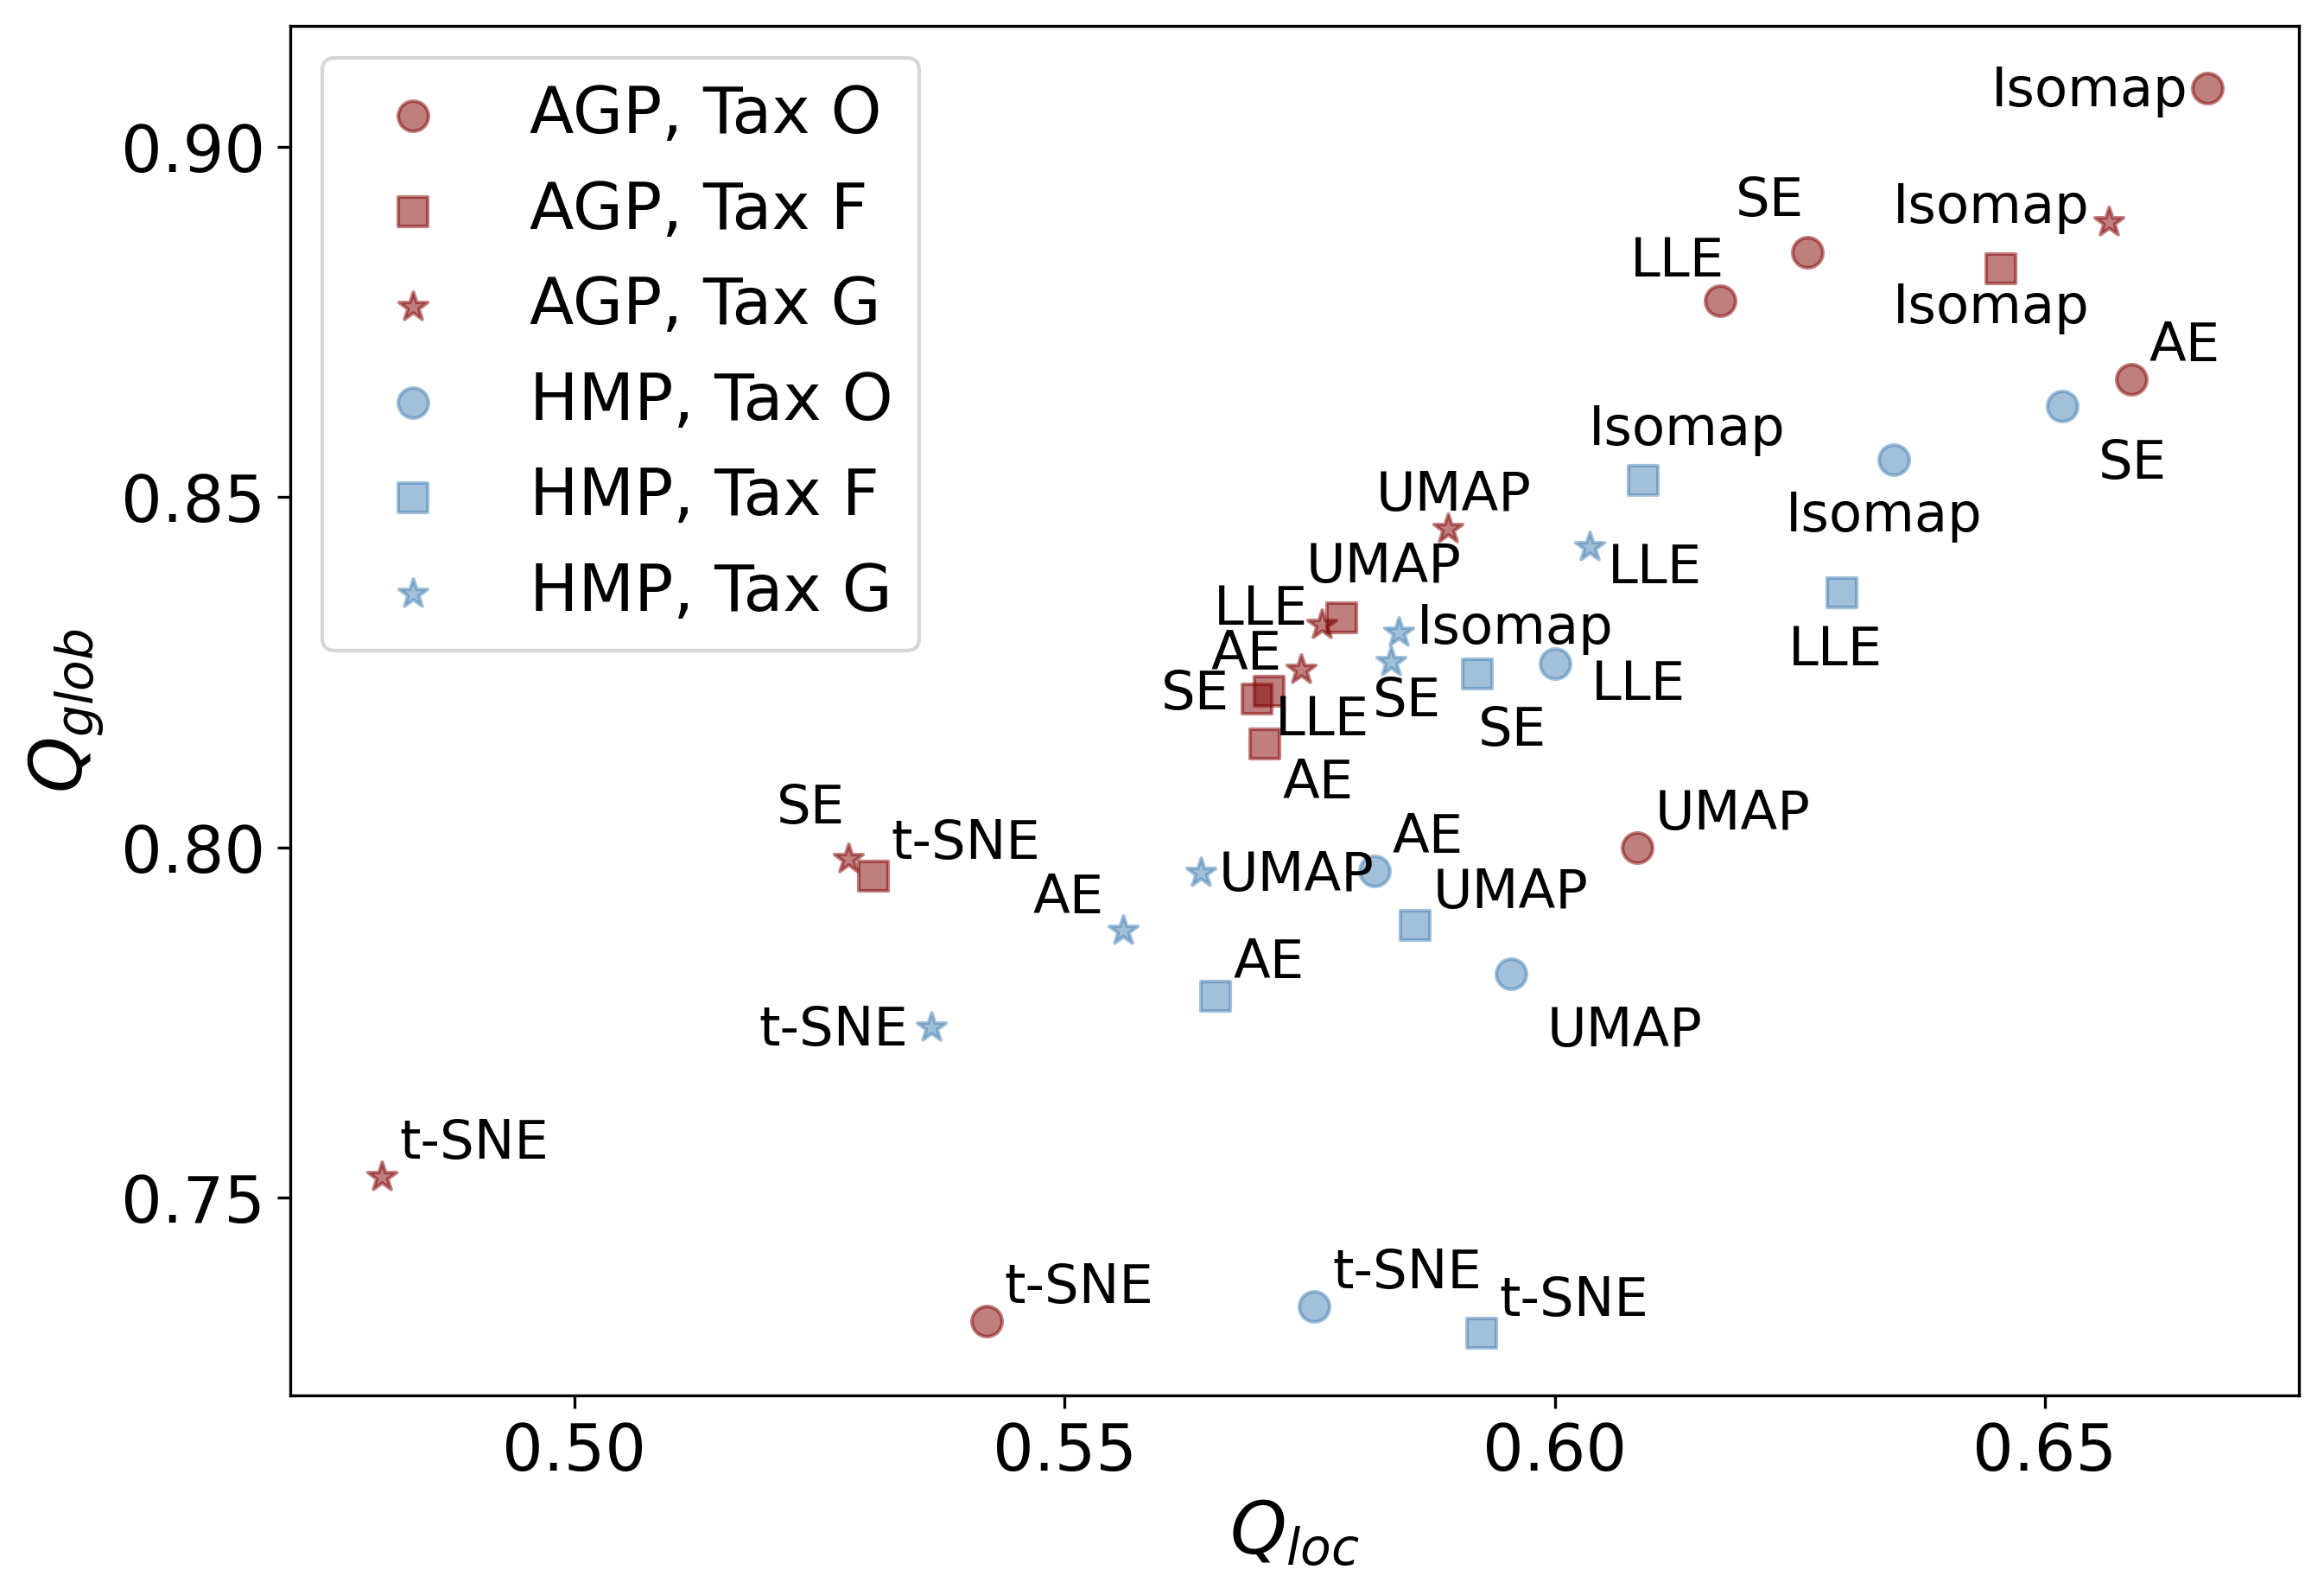

In [122]:
MSIZE=70

xytext_positions_dict = {'':xytext_positions_nopat,
                         '_pat0.7':xytext_positions_pat07}

fig=plt.figure(figsize=(10,7),dpi=300)
fig.set_facecolor('white')
plt.xlabel(r"$Q_{loc}$", fontsize=20)
plt.ylabel(r"$Q_{glob}$", fontsize=20)

embeddingname_dict = {'spectral':'SE',
                       'ae':'AE',
                       'tsne':'t-SNE',
                       'umap':'UMAP',
                       'isomap':'Isomap',
                       'lle':'LLE',
                       'pca': 'PCA'}

markerdict = {
    'o':'o',
    'f':'s',
    'g':'*',
}

for dataset_name in ['AGP', 'HMP']:
    for tax_name in ['o', 'f', 'g']:
        label = dataset_name + '_' + tax_name
        
        data_embeddings_label = data_embeddings[label]
        
        for i, (embedding_name, metrics_dict) in enumerate(data_embeddings_label.items()):

            x = metrics_dict['Q_loc']
            y = metrics_dict['Q_glob']

            marker = markerdict[tax_name]
            color = 'maroon' if dataset_name == 'AGP' else 'steelblue'

            legend_label = f'{dataset_name}, Tax {tax_name.capitalize()}' if i == 0 else None
            
            mp = plt.scatter(x, 
                             y, 
                             c=color, 
                             s=MSIZE, 
                             marker=marker, 
                             alpha=0.5,
                             label=legend_label)
    
            txt = embeddingname_dict[embedding_name]
            
            # adjusting text position
            try:
                xytext = xytext_positions_dict[DATA_SPECIFICATION][label + '_' + embedding_name]
            except:
                xytext = (5,5)

            plt.annotate(txt, 
                         (x, y), 
                         annotation_clip=True, 
                         fontsize=15, 
                         xytext=xytext, 
                         textcoords="offset points")
    
plt.legend(fontsize=18)
plt.locator_params(nbins=5)
plt.tick_params(axis='both', labelsize=18)
plt.show()